## Setup and Imports

In [12]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
import random
import json

# Configuration
API_URL = "http://localhost:8000"
DATASET_PATH = Path("dataset_generator/dataset/valid")
CLASSES = ["aadhar", "driving", "pan", "passport", "voter"]

print("✅ Imports successful")
print(f"📂 Dataset path: {DATASET_PATH.absolute()}")
print(f"🌐 API URL: {API_URL}")

✅ Imports successful
📂 Dataset path: c:\Users\Lenovo\OneDrive - wilp.bits-pilani.ac.in\Documents\AIML\kyc-aml-document-classifier\dataset_generator\dataset\valid
🌐 API URL: http://localhost:8000


## Check API Health

In [10]:
def check_api_health():
    """Check if API is running and model is loaded"""
    try:
        response = requests.get(f"{API_URL}/health", timeout=5)
        if response.status_code == 200:
            health_data = response.json()
            print("✅ API is running")
            print(f"   Status: {health_data.get('status')}")
            print(f"   Model loaded: {health_data.get('model_loaded')}")
            return health_data.get('model_loaded', False)
        else:
            print(f"❌ API returned status code: {response.status_code}")
            return False
    except requests.exceptions.ConnectionError:
        print("❌ Cannot connect to API. Make sure the server is running:")
        print("   python -m uvicorn api.main:app --port 8000")
        return False
    except Exception as e:
        print(f"❌ Error: {e}")
        return False

# Check API
model_loaded = check_api_health()

✅ API is running
   Status: healthy
   Model loaded: True


## Select Sample Images from Each Class

In [18]:
def get_sample_images(dataset_path, classes, num_samples=1):
    """Get random sample images from each class"""
    samples = {}
    
    for class_name in classes:
        class_path = dataset_path / class_name
        
        if not class_path.exists():
            print(f"⚠️  Warning: {class_path} not found")
            continue
        
        # Get all image files
        image_files = list(class_path.glob("*.jpg")) + list(class_path.glob("*.jpeg")) + list(class_path.glob("*.png"))
        
        if not image_files:
            print(f"⚠️  Warning: No images found in {class_path}")
            continue
        
        # Select random samples
        selected = random.sample(image_files, min(num_samples, len(image_files)))
        samples[class_name] = selected
        
        print(f"✅ {class_name:10s}: {len(image_files):3d} images available, selected {len(selected)}")
    
    return samples

# Get one sample image per class
print("\n📸 Selecting sample images...\n")
sample_images = get_sample_images(DATASET_PATH, CLASSES, num_samples=1)

print(f"\n✅ Total samples selected: {sum(len(v) for v in sample_images.values())}")


📸 Selecting sample images...

✅ aadhar    :  35 images available, selected 1
✅ driving   :  37 images available, selected 1
✅ pan       :  90 images available, selected 1
✅ passport  :  60 images available, selected 1
✅ voter     :  38 images available, selected 1

✅ Total samples selected: 5


## Define Prediction Function

In [14]:
def predict_image(image_path, api_url=API_URL):
    """Send image to prediction endpoint and get results"""
    try:
        with open(image_path, 'rb') as f:
            files = {'file': (image_path.name, f, 'image/jpeg')}
            response = requests.post(f"{api_url}/predict", files=files, timeout=30)
        
        if response.status_code == 200:
            return response.json()
        else:
            return {
                'success': False,
                'error': f"Status code: {response.status_code}",
                'message': response.text
            }
    except Exception as e:
        return {
            'success': False,
            'error': str(e)
        }

print("✅ Prediction function defined")

✅ Prediction function defined


## Test Predictions with Visual Results

In [15]:
def display_prediction_result(image_path, true_class, prediction_result):
    """Display image and prediction results side by side"""
    
    # Create figure with 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Display image
    img = Image.open(image_path)
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title(f"True Class: {true_class.upper()}\nFile: {image_path.name}", 
                  fontsize=12, fontweight='bold')
    
    # Display prediction results
    ax2.axis('off')
    
    if prediction_result.get('success', False):
        predicted_class = prediction_result['predicted_class']
        confidence = prediction_result['confidence']
        all_probs = prediction_result['all_probabilities']
        
        # Determine if prediction is correct
        is_correct = predicted_class.lower() == true_class.lower()
        result_color = 'green' if is_correct else 'red'
        result_symbol = '✅' if is_correct else '❌'
        
        # Create result text
        result_text = f"""{result_symbol} Prediction Result\n
{'='*40}\n
Predicted Class: {predicted_class.upper()}\n
Confidence: {confidence*100:.2f}%\n
{'='*40}\n
All Class Probabilities:\n"""
        
        # Sort probabilities
        sorted_probs = sorted(all_probs.items(), key=lambda x: x[1], reverse=True)
        
        for class_name, prob in sorted_probs:
            bar = '█' * int(prob * 30)
            result_text += f"\n{class_name:10s}: {prob*100:5.2f}% {bar}"
        
        # Add correctness indicator
        result_text += f"\n\n{'='*40}\n"
        if is_correct:
            result_text += "\n✅ CORRECT PREDICTION!"
        else:
            result_text += f"\n❌ INCORRECT\nExpected: {true_class.upper()}"
        
        ax2.text(0.05, 0.95, result_text, 
                verticalalignment='top',
                fontfamily='monospace',
                fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Color the title
        ax2.set_title("API Response", fontsize=12, fontweight='bold', color=result_color)
    else:
        # Display error
        error_text = f"""❌ Prediction Failed\n
{'='*40}\n
Error: {prediction_result.get('error', 'Unknown error')}\n
Message: {prediction_result.get('message', 'N/A')}"""
        
        ax2.text(0.05, 0.95, error_text, 
                verticalalignment='top',
                fontfamily='monospace',
                fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
        ax2.set_title("API Response", fontsize=12, fontweight='bold', color='red')
    
    plt.tight_layout()
    plt.show()

print("✅ Display function defined")

✅ Display function defined


## Run Predictions for All Sample Images

🔮 Running predictions...


🔍 Testing: AADHAR - adhaar_img-162-_jpg.rf.bee043078b091de03c6c49071253a409.jpg


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23608\3097556382.py:71: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
c:\Users\Lenovo\anaconda3\envs\kyc-aml-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


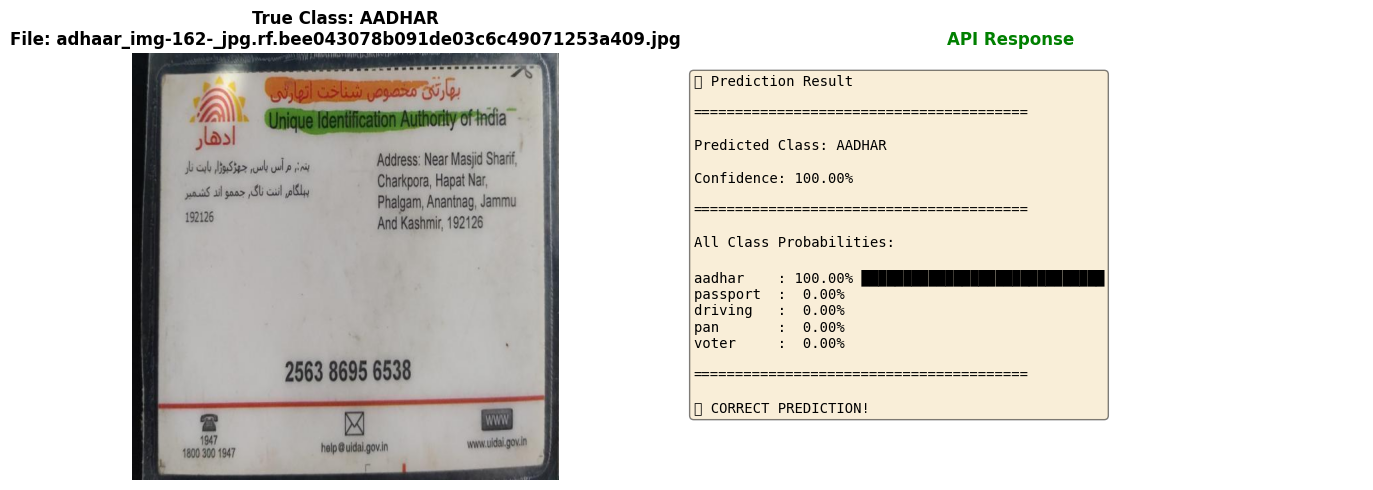


🔍 Testing: DRIVING - DL1323_png_jpg.rf.456752d4a21cd393dda5411cfd61972c.jpg


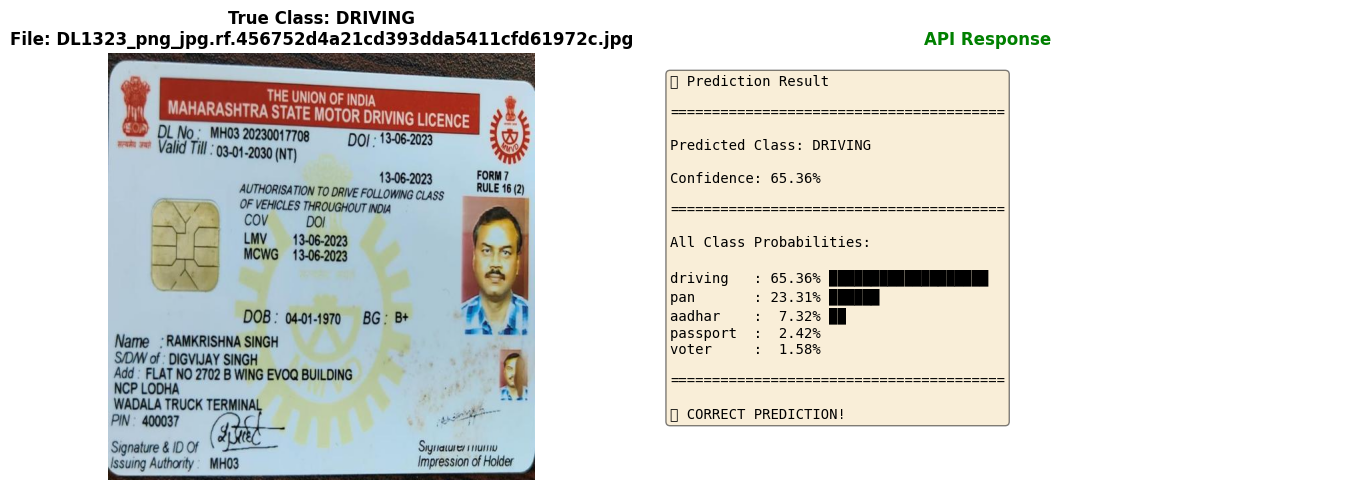


🔍 Testing: PAN - bnw_image_262_jpg.rf.f374b7a3be09a2d9db02379b7746cac4.jpg


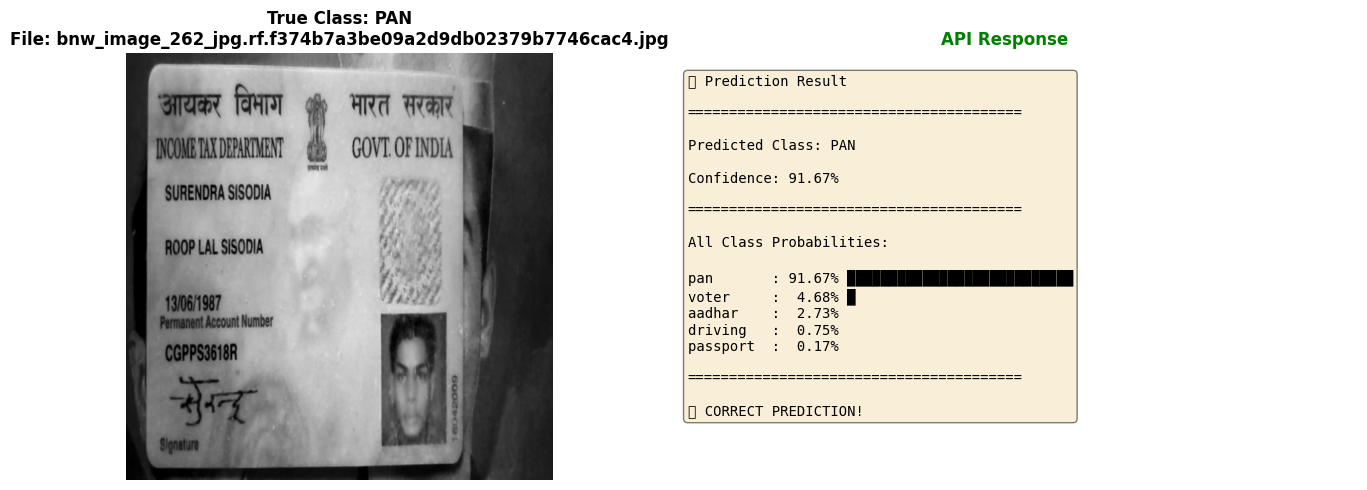


🔍 Testing: PASSPORT - passport_0041.jpg


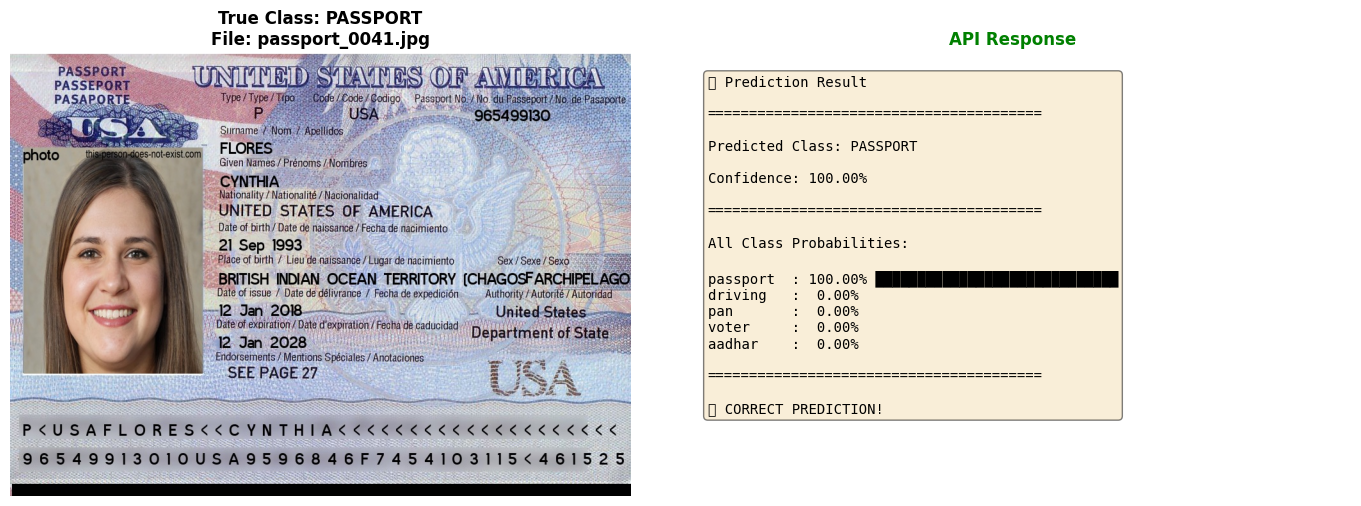


🔍 Testing: VOTER - FIL220705120424627TTVMGFZEDRRF42_jpg.rf.1485a7f291683e98c2ba434177a6fbce.jpg


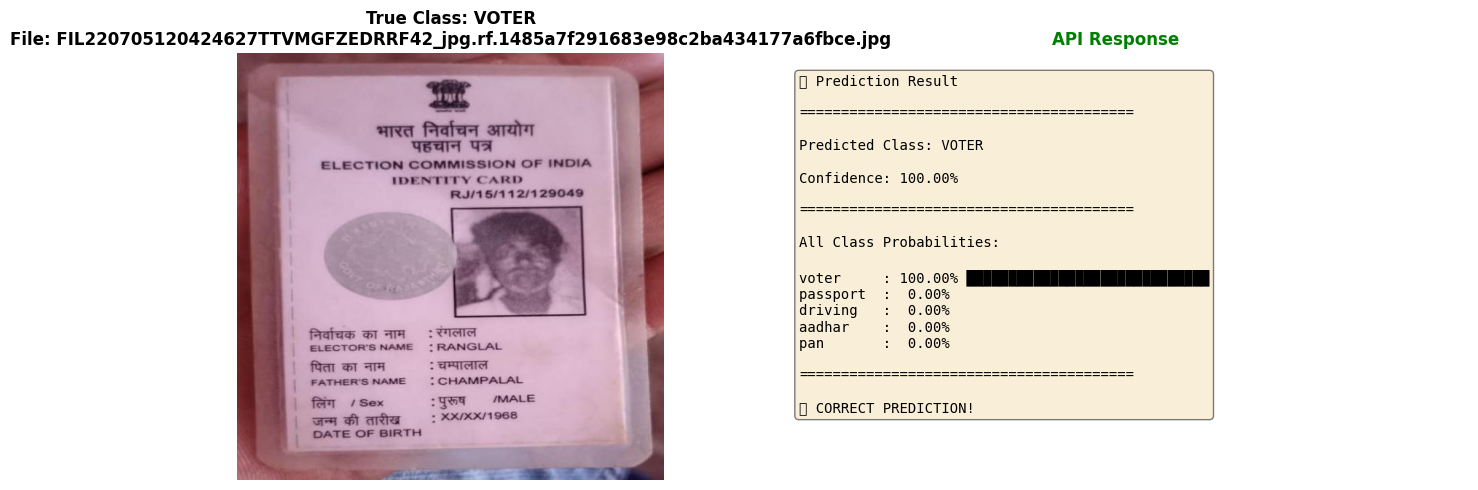


📊 SUMMARY

Total Predictions: 5
Correct: 5
Incorrect: 0
Accuracy: 100.00%



In [19]:
if not model_loaded:
    print("❌ Model not loaded. Please ensure the API server is running with the model loaded.")
    print("   Start the server: python -m uvicorn api.main:app --port 8000")
else:
    print("🔮 Running predictions...\n")
    print("=" * 60)
    
    results_summary = []
    
    for class_name, image_paths in sample_images.items():
        for image_path in image_paths:
            print(f"\n🔍 Testing: {class_name.upper()} - {image_path.name}")
            
            # Make prediction
            prediction = predict_image(image_path)
            
            # Store result
            is_correct = prediction.get('predicted_class', '').lower() == class_name.lower() if prediction.get('success') else False
            results_summary.append({
                'true_class': class_name,
                'predicted_class': prediction.get('predicted_class', 'N/A'),
                'confidence': prediction.get('confidence', 0),
                'correct': is_correct
            })
            
            # Display result
            display_prediction_result(image_path, class_name, prediction)
            
            print("=" * 60)
    
    # Summary
    print("\n" + "=" * 60)
    print("📊 SUMMARY")
    print("=" * 60)
    
    total = len(results_summary)
    correct = sum(1 for r in results_summary if r['correct'])
    accuracy = (correct / total * 100) if total > 0 else 0
    
    print(f"\nTotal Predictions: {total}")
    print(f"Correct: {correct}")
    print(f"Incorrect: {total - correct}")
    print(f"Accuracy: {accuracy:.2f}%")
    
    print("\n" + "=" * 60)

## Detailed Results Table

In [20]:
if model_loaded and results_summary:
    import pandas as pd
    
    # Create DataFrame
    df = pd.DataFrame(results_summary)
    df['confidence_pct'] = df['confidence'].apply(lambda x: f"{x*100:.2f}%")
    df['result'] = df['correct'].apply(lambda x: '✅ Correct' if x else '❌ Incorrect')
    
    # Display table
    print("\n📋 Detailed Results:\n")
    display(df[['true_class', 'predicted_class', 'confidence_pct', 'result']])
    
    # Confusion info
    print("\n🔍 Misclassifications:")
    misclassified = df[~df['correct']]
    if len(misclassified) > 0:
        for _, row in misclassified.iterrows():
            print(f"   ❌ {row['true_class']:10s} → {row['predicted_class']:10s} (confidence: {row['confidence_pct']})")
    else:
        print("   ✅ No misclassifications! Perfect accuracy!")


📋 Detailed Results:



,true_class,predicted_class,confidence_pct,result
0,aadhar,aadhar,100.00%,✅ Correct
1,driving,driving,65.36%,✅ Correct
2,pan,pan,91.67%,✅ Correct
3,passport,passport,100.00%,✅ Correct
4,voter,voter,100.00%,✅ Correct



🔍 Misclassifications:
   ✅ No misclassifications! Perfect accuracy!


## Test with Custom Image (Optional)

You can test with your own image by providing the path below:

In [8]:
# Uncomment and modify the path to test with a custom image

# custom_image_path = Path("path/to/your/image.jpg")
# custom_true_class = "aadhar"  # Expected class

# if custom_image_path.exists():
#     print(f"🔍 Testing custom image: {custom_image_path.name}\n")
#     custom_prediction = predict_image(custom_image_path)
#     display_prediction_result(custom_image_path, custom_true_class, custom_prediction)
# else:
#     print("❌ Custom image not found")

print("💡 Uncomment the code above to test with a custom image")

💡 Uncomment the code above to test with a custom image


## Batch Testing (Optional)

Test multiple images from each class:

In [9]:
# Uncomment to test with multiple images per class

# NUM_SAMPLES_PER_CLASS = 3

# print(f"\n📸 Selecting {NUM_SAMPLES_PER_CLASS} samples per class...\n")
# batch_samples = get_sample_images(DATASET_PATH, CLASSES, num_samples=NUM_SAMPLES_PER_CLASS)

# batch_results = []

# for class_name, image_paths in batch_samples.items():
#     for image_path in image_paths:
#         prediction = predict_image(image_path)
#         is_correct = prediction.get('predicted_class', '').lower() == class_name.lower() if prediction.get('success') else False
#         batch_results.append({
#             'true_class': class_name,
#             'predicted_class': prediction.get('predicted_class', 'N/A'),
#             'confidence': prediction.get('confidence', 0),
#             'correct': is_correct
#         })

# # Display summary
# batch_df = pd.DataFrame(batch_results)
# print("\n📊 Batch Test Summary:")
# print(f"Total: {len(batch_df)}")
# print(f"Correct: {batch_df['correct'].sum()}")
# print(f"Accuracy: {batch_df['correct'].mean()*100:.2f}%")
# print("\nBy Class:")
# display(batch_df.groupby('true_class')['correct'].agg(['count', 'sum', 'mean']))

print("💡 Uncomment the code above to run batch testing")

💡 Uncomment the code above to run batch testing
